# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable

## Introduction

This challenge aims to improve the bike-sharing service in cities, representing a significant opportunity to reduce car traffic and help the fight against climate change. 

We started our analysis with an exploratory data analysis which highlighted the impact of COVID on bike-sharing. To improve bike-sharing, we developed a model predicting the number of slots in the station of origin. We could then use this model to optimize the number of slots in each station and increase bike-sharing users. 

This notebook can be vizualized on [Google Collab](https://colab.research.google.com/drive/14SR5gZjklAad0t6DFrEDBNUqzMQzP21-?usp=sharing).

## Development

### Initialize

In [52]:
# Mount the drive folder
from google.colab import drive # to load data from google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import os # For files operations
import warnings
import itertools
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import urllib.request # For download from url
import matplotlib.pyplot as plt # ploting the data
import seaborn as sns # ploting the data
import csv # to import data in txt files
from datetime import datetime

In [54]:
# to use Panda profilling
# See the output to NULL for notebook readibility
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip > NULL
from pandas_profiling import ProfileReport

In [55]:
# Set up color blind friendly color palette
# The palette with grey:
cbPalette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
# The palette with black:
cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# sns.palplot(sns.color_palette(cbPalette))
# sns.palplot(sns.color_palette(cbbPalette))

sns.set_palette(cbPalette)
#sns.set_palette(cbbPalette)

In [56]:
# Seaborn plot shortcuts
def boxplot(data, x, y, title = ""):
    
    """
    This function generates a seaborn boxplot with my defaults parameters.

    Parameters:
        title (string) title of the plot, default is empty
        data (df) the data frame
        x (panda serie) the x axis
        y (panda serie) the y axis
    """

    f, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x=x, y=y, data=data, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
    plt.title(title)
    plt.ioff()

def countplot(data, variable, title = ""):
    """
    This function contains my favourite parameters for the seaborn coutplot plot
    """

    f, ax = plt.subplots(figsize=(8, 6))
    sns.countplot(data=data, x=variable)
    plt.title(title)
    plt.ioff()

In [57]:
# Set up the path for the data and output folders
PATH = "/content/drive/MyDrive/Data_science/WDL/Stage3/"
data = PATH + "Data"
output = PATH + "Output"

os.listdir(data)

['bike_loans.csv',
 'data_dict.csv',
 'station_location_with_id.csv',
 'medellin_bus_routes',
 'medellin_metro_stations',
 'bike_loans_merged.csv']

### Exploratory Data Analysis

In [58]:
file = data + "/" + "bike_loans_merged.csv"
df=pd.read_csv(file) #read the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14225355 entries, 0 to 14225354
Data columns (total 23 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Unnamed: 0                        int64  
 1   Loan_ID                           int64  
 2   User_ID                           int64  
 3   Bike_Tag_ID                       object 
 4   Loan_start_date_time              object 
 5   Loan_stop_date_time               object 
 6   Origin_loan_station_ID            int64  
 7   Position_number_bike_origin       int64  
 8   Return_loan_station_ID            float64
 9   Position_number_bike_destination  float64
 10  operator_presence                 object 
 11  Origin_station_description        object 
 12  origin_station_slots              float64
 13  origin_station_short_name         object 
 14  Origin_Lat                        object 
 15  Origin_Lon                        object 
 16  Origin_isManual                   

**The number of observation in this dataset is large. It caused out of memory issues while running the analysis on Google Collab pro.
To develop a proof of concept model using the computing resources available, we decided to randomly select 10% of the dataset for further analysis at this time.**

In [59]:
# Drop NaN values
df = df.dropna()

# Select 10% of the dataset
df = df.sample(frac=0.10)

# Save the samples data frame
file = data + "/" + "sample_bike_loans_merged.csv"
df.to_csv(file, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329383 entries, 0 to 1329382
Data columns (total 23 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Unnamed: 0                        1329383 non-null  int64  
 1   Loan_ID                           1329383 non-null  int64  
 2   User_ID                           1329383 non-null  int64  
 3   Bike_Tag_ID                       1329383 non-null  object 
 4   Loan_start_date_time              1329383 non-null  object 
 5   Loan_stop_date_time               1329383 non-null  object 
 6   Origin_loan_station_ID            1329383 non-null  int64  
 7   Position_number_bike_origin       1329383 non-null  int64  
 8   Return_loan_station_ID            1329383 non-null  float64
 9   Position_number_bike_destination  1329383 non-null  float64
 10  operator_presence                 1329383 non-null  object 
 11  Origin_station_description        132

In [93]:
# Checkpoint load the new dataset
file = data + "/" + "sample_bike_loans_merged.csv"
df=pd.read_csv(file) #read the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329383 entries, 0 to 1329382
Data columns (total 23 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Unnamed: 0                        1329383 non-null  int64  
 1   Loan_ID                           1329383 non-null  int64  
 2   User_ID                           1329383 non-null  int64  
 3   Bike_Tag_ID                       1329383 non-null  object 
 4   Loan_start_date_time              1329383 non-null  object 
 5   Loan_stop_date_time               1329383 non-null  object 
 6   Origin_loan_station_ID            1329383 non-null  int64  
 7   Position_number_bike_origin       1329383 non-null  int64  
 8   Return_loan_station_ID            1329383 non-null  float64
 9   Position_number_bike_destination  1329383 non-null  float64
 10  operator_presence                 1329383 non-null  object 
 11  Origin_station_description        132

In [94]:
df.head()

,Unnamed: 0,Loan_ID,User_ID,Bike_Tag_ID,Loan_start_date_time,Loan_stop_date_time,Origin_loan_station_ID,Position_number_bike_origin,Return_loan_station_ID,Position_number_bike_destination,operator_presence,Origin_station_description,origin_station_slots,origin_station_short_name,Origin_Lat,Origin_Lon,Origin_isManual,Return_station_description,return_station_slots,return_station_short_name,Return_Lat,Return_Lon,Return_isManual
0,2309120,1224740,16612,SA23,2015-11-19 07:17:56.000,2015-11-19 07:21:59.000,27,1,28.0,1.0,Present,Sabaneta Parque,1.0,SPQ,"6,151631","-75,615623",1.0,Sabaneta Metro,1.0,SMT,"6,1568288","-75,616668",1.0
1,5571904,8072708,95087,000017AFBE15,2018-02-27 10:20:57.000,2018-02-27 10:23:32.000,64,13,59.0,21.0,Absent,MAMM,38.0,MUM,"6,22378","-75,574966",0.0,Río Aburrá,26.0,BCO,"6,22851","-75,574658",0.0
2,125768,4914381,44571,000017AFBBCF,2016-10-21 18:11:45.000,2016-10-21 18:26:48.000,60,25,36.0,28.0,Absent,Villa Carlota,26.0,VCA,"6,220012","-75,575431",0.0,Parque de Las Luces I,28.0,CIS,"6,246078","-75,571561",0.0
3,12627185,15556172,139715,0000EC016FE2,2020-05-09 11:12:55.000,2020-05-09 11:35:38.000,12,1,89.0,14.0,Absent,Floresta,20.0,FLO,"6,258628","-75,597366",1.0,Málaga,20.0,MLG,"6,24655","-75,569954",0.0
4,9049839,11604612,92632,003567222B5E,2019-04-25 06:22:21.000,2019-04-25 06:42:15.000,66,1,47.0,20.0,Absent,Industriales Metroplús,20.0,IMP,"6,231406","-75,577222",1.0,Circular Primera,24.0,CRP,"6,241859","-75,591929",0.0


In [95]:
df.tail()

,Unnamed: 0,Loan_ID,User_ID,Bike_Tag_ID,Loan_start_date_time,Loan_stop_date_time,Origin_loan_station_ID,Position_number_bike_origin,Return_loan_station_ID,Position_number_bike_destination,operator_presence,Origin_station_description,origin_station_slots,origin_station_short_name,Origin_Lat,Origin_Lon,Origin_isManual,Return_station_description,return_station_slots,return_station_short_name,Return_Lat,Return_Lon,Return_isManual
1329378,6590302,9116840,112945,0000190C583F,2018-07-09 05:29:34.000,2018-07-09 05:46:32.000,2,1,64.0,29.0,Absent,Universidad,33.0,UNI,"6,269267","-75,5653",1.0,MAMM,38.0,MUM,"6,22378","-75,574966",0.0
1329379,8727385,11276830,116806,006B91222B5E,2019-03-20 20:51:58.000,2019-03-20 21:13:21.000,70,1,8.0,1.0,Present,Campus Nacional,33.0,NAC,"6,260703","-75,57858",1.0,Estadio,20.0,EST,"6,253349","-75,587692",1.0
1329380,13767223,16781824,142327,00005B1D8DC7,2021-01-25 15:33:37.000,2021-01-25 15:35:45.000,90,13,90.0,14.0,Absent,Calle 51 Los Colores,40.0,C51,"6,26337958","-75,59509188",0.0,Calle 51 Los Colores,40.0,C51,"6,26337958","-75,59509188",0.0
1329381,4081655,6383321,97407,000017AFE676,2017-06-02 13:43:06.000,2017-06-02 13:47:36.000,46,1,8.0,1.0,Present,María Mulata,24.0,FNU,"6,250549","-75,594719",0.0,Estadio,20.0,EST,"6,253349","-75,587692",1.0
1329382,6906106,9431967,114500,0000190C99DE,2018-08-16 17:23:12.000,2018-08-16 17:30:38.000,10,1,49.0,5.0,Absent,UPB,12.0,UPB,"6,244998","-75,589188",1.0,Pedro Nel Gómez,26.0,NTB,"6,246906","-75,596625",0.0


In [96]:
# Exclude non-useful variables

df = df.drop('Unnamed: 0',axis=1)
df = df.drop('Loan_ID',axis=1)
df = df.drop('User_ID',axis=1)
df = df.drop('origin_station_short_name',axis=1)
df = df.drop('return_station_short_name',axis=1)

df.head()

,Bike_Tag_ID,Loan_start_date_time,Loan_stop_date_time,Origin_loan_station_ID,Position_number_bike_origin,Return_loan_station_ID,Position_number_bike_destination,operator_presence,Origin_station_description,origin_station_slots,Origin_Lat,Origin_Lon,Origin_isManual,Return_station_description,return_station_slots,Return_Lat,Return_Lon,Return_isManual
0,SA23,2015-11-19 07:17:56.000,2015-11-19 07:21:59.000,27,1,28.0,1.0,Present,Sabaneta Parque,1.0,"6,151631","-75,615623",1.0,Sabaneta Metro,1.0,"6,1568288","-75,616668",1.0
1,000017AFBE15,2018-02-27 10:20:57.000,2018-02-27 10:23:32.000,64,13,59.0,21.0,Absent,MAMM,38.0,"6,22378","-75,574966",0.0,Río Aburrá,26.0,"6,22851","-75,574658",0.0
2,000017AFBBCF,2016-10-21 18:11:45.000,2016-10-21 18:26:48.000,60,25,36.0,28.0,Absent,Villa Carlota,26.0,"6,220012","-75,575431",0.0,Parque de Las Luces I,28.0,"6,246078","-75,571561",0.0
3,0000EC016FE2,2020-05-09 11:12:55.000,2020-05-09 11:35:38.000,12,1,89.0,14.0,Absent,Floresta,20.0,"6,258628","-75,597366",1.0,Málaga,20.0,"6,24655","-75,569954",0.0
4,003567222B5E,2019-04-25 06:22:21.000,2019-04-25 06:42:15.000,66,1,47.0,20.0,Absent,Industriales Metroplús,20.0,"6,231406","-75,577222",1.0,Circular Primera,24.0,"6,241859","-75,591929",0.0


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329383 entries, 0 to 1329382
Data columns (total 18 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Bike_Tag_ID                       1329383 non-null  object 
 1   Loan_start_date_time              1329383 non-null  object 
 2   Loan_stop_date_time               1329383 non-null  object 
 3   Origin_loan_station_ID            1329383 non-null  int64  
 4   Position_number_bike_origin       1329383 non-null  int64  
 5   Return_loan_station_ID            1329383 non-null  float64
 6   Position_number_bike_destination  1329383 non-null  float64
 7   operator_presence                 1329383 non-null  object 
 8   Origin_station_description        1329383 non-null  object 
 9   origin_station_slots              1329383 non-null  float64
 10  Origin_Lat                        1329383 non-null  object 
 11  Origin_Lon                        132

In [64]:
# This code created an out of mermory issue on Google Colab Pro even with High Memory env. for the full dataset

report = ProfileReport(df, minimal=True)
# Display the report
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Target Variable Distribution

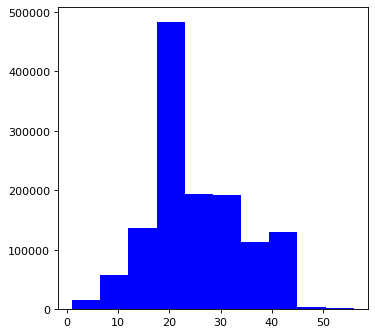

In [98]:
# Target Variable distribution: origin_station_slots
plt.figure(figsize=(5, 5), dpi=80)
plt.hist(df['origin_station_slots'], color='blue')
plt.show()

#### Analysis of the independent variables

In [99]:
# Gather the data for the highest origin loan rate station
highest_rental_station = df.groupby(["Origin_station_description"])['Origin_loan_station_ID'].count()
highest_rental_station_df= pd.DataFrame(highest_rental_station)#Convert the series into dataframe
highest_rental_station_df.columns =['Total Loans']#rename the columns for better understanding
highest_rental_station_df

,Total Loans
Origin_station_description,
Auxiliar Metro Envigado,232
Aves María,793
Bahía Ciclovia,60
Batallón,13437
Biblioteca Sabaneta,372
...,...
Villa Carlota,14658
Villa Paula,124
Villas de vallejuelos,305


In [100]:
# Finding the top rental stations
highest_rental_station_df.sort_values(by=['Total Loans'], inplace=True,ascending=False)
highest_rental_station_df.dropna(inplace=True)

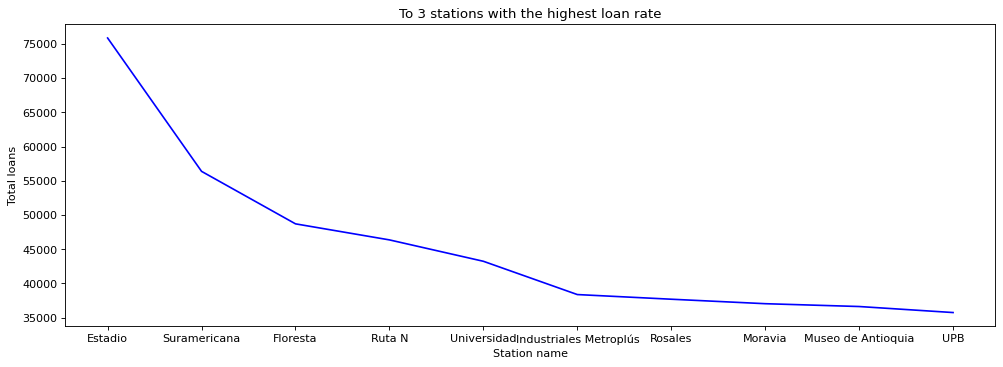

In [102]:
# Display only the top 10 stations with the highest loan rate
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(highest_rental_station_df.head(10), color = "blue")

plt.title("Top 3 stations with the highest loan rate")
plt.xlabel('Station name')
plt.ylabel('Total loans')
plt.show()

From looking at the graph its clear that the stations:
* Estadio
* Suramericana
* Floresta

These are the top 3 stations with the highest loan rate

In [104]:
# Find the highest return loan rate station
highest_return_station = df.groupby(["Return_station_description"])['Return_loan_station_ID'].count()
highest_return_station_df= pd.DataFrame(highest_return_station)#Convert the series into dataframe
highest_return_station_df.columns =['Total Loans']#rename the columns for better understanding
highest_return_station_df

,Total Loans
Return_station_description,
Auxiliar Metro Envigado,260
Aves María,735
Bahía Ciclovia,59
Batallón,12865
Biblioteca Sabaneta,313
...,...
Villa Carlota,16720
Villa Paula,110
Villas de vallejuelos,279


In [105]:
highest_return_station_df.sort_values(by=['Total Loans'], inplace = True,ascending=False)
highest_return_station_df

,Total Loans
Return_station_description,
Estadio,70684
Suramericana,54884
Floresta,53345
Ruta N,47417
Universidad,42712
...,...
Los Naranjos,59
Bahía Ciclovia,59
Metróplus Cami,57


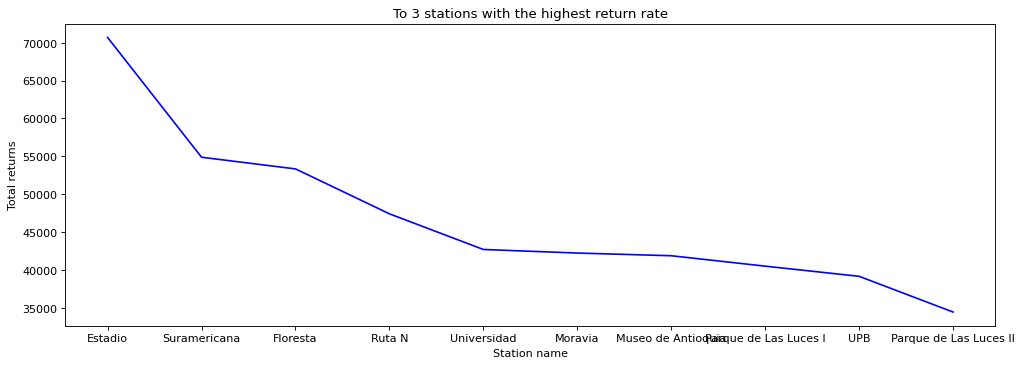

In [107]:
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(highest_return_station_df.head(10), color = 'blue')

plt.title("Top 3 stations with the highest return rate")
plt.xlabel('Station name')
plt.ylabel('Total returns')
plt.show()

Conclusion: Since these are the top 3 stations, maybe the business model can accomodate more slots to these stations as it has the highest number of loan/return rate

Station1 : Estadio station analysis

In [109]:
# Get the data for the estadio station to find the yearly trend
estadio_station = df[df['Origin_station_description']=='Estadio']
estadio_station

,Bike_Tag_ID,Loan_start_date_time,Loan_stop_date_time,Origin_loan_station_ID,Position_number_bike_origin,Return_loan_station_ID,Position_number_bike_destination,operator_presence,Origin_station_description,origin_station_slots,Origin_Lat,Origin_Lon,Origin_isManual,Return_station_description,return_station_slots,Return_Lat,Return_Lon,Return_isManual
43,00D43C222B5E,2019-03-05 07:24:36.000,2019-03-05 07:36:42.000,8,1,22.0,12.0,Absent,Estadio,20.0,"6,253349","-75,587692",1.0,Primer Parque de Laureles,32.0,"6,24597","-75,593812",0.0
87,00A377222B5E,2019-09-10 14:43:42.000,2019-09-10 14:49:59.000,8,1,10.0,1.0,Present,Estadio,20.0,"6,253349","-75,587692",1.0,UPB,12.0,"6,244998","-75,589188",1.0
128,000054612B75,2020-08-26 17:55:41.000,2020-08-26 18:04:56.000,8,1,19.0,1.0,Absent,Estadio,20.0,"6,253349","-75,587692",1.0,Plaza de La Libertad,38.0,"6,2434627","-75,5746534",0.0
129,000017B04820,2015-03-31 09:54:32.000,2015-03-31 10:10:13.000,8,1,47.0,5.0,Absent,Estadio,20.0,"6,253349","-75,587692",1.0,Circular Primera,24.0,"6,241859","-75,591929",0.0
147,0000164C359F,2017-05-24 14:55:58.000,2017-05-24 15:07:08.000,8,1,40.0,11.0,Absent,Estadio,20.0,"6,253349","-75,587692",1.0,Orquídeas,40.0,"6,262605","-75,58895",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329325,000C70222B5E,2019-10-09 18:17:11.000,2019-10-09 18:22:51.000,8,1,11.0,6.0,Absent,Estadio,20.0,"6,253349","-75,587692",1.0,Los Colores,22.0,"6,260004","-75,585136",0.0
1329331,0000362C0776,2020-08-31 17:12:15.000,2020-08-31 17:12:56.000,8,1,8.0,1.0,Present,Estadio,20.0,"6,253349","-75,587692",1.0,Estadio,20.0,"6,253349","-75,587692",1.0
1329342,000017AFFBC1,2017-04-12 07:38:59.000,2017-04-12 07:57:26.000,8,1,66.0,1.0,Present,Estadio,20.0,"6,253349","-75,587692",1.0,Industriales Metroplús,20.0,"6,231406","-75,577222",1.0
1329348,0000AC99B7E2,2021-02-01 05:33:37.000,2021-02-01 05:42:07.000,8,1,47.0,16.0,Absent,Estadio,20.0,"6,253349","-75,587692",1.0,Circular Primera,24.0,"6,241859","-75,591929",0.0


In [ ]:
from datetime import datetime

In [114]:
estadio_station['Loan_start_date_time'] = pd.to_datetime(estadio_station['Loan_start_date_time']).dt.date
yearly_loans = estadio_station.groupby(["Loan_start_date_time"])["Origin_loan_station_ID"].count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [115]:
estadio_station_df= pd.DataFrame(yearly_loans)#Convert the series into dataframe
estadio_station_df.columns =['Total Loans']#rename the columns for better understanding
estadio_station_df

,Total Loans
Loan_start_date_time,
2014-06-03,12
2014-06-04,6
2014-06-05,10
2014-06-06,7
2014-06-09,12
...,...
2021-04-13,40
2021-04-14,36
2021-04-15,38


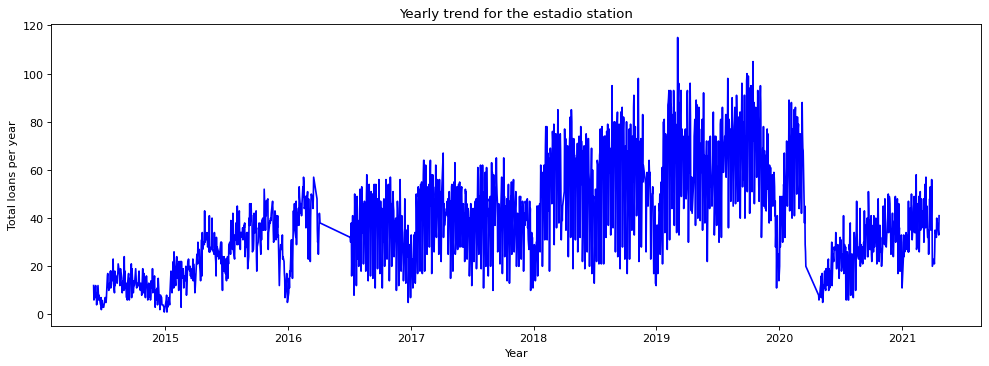

In [117]:
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(estadio_station_df, color = 'blue')

plt.title("Yearly trend for the estadio station")
plt.xlabel('Year')
plt.ylabel('Total loans per year')
plt.show()

From this we can see the bike sharing increasing during 2018-2020 and 2020 half it dropped maybe due to covid

Station 2: Suramericana station analysis

In [119]:
Suramericana_station = df[df['Origin_station_description']=='Suramericana']
Suramericana_station

,Bike_Tag_ID,Loan_start_date_time,Loan_stop_date_time,Origin_loan_station_ID,Position_number_bike_origin,Return_loan_station_ID,Position_number_bike_destination,operator_presence,Origin_station_description,origin_station_slots,Origin_Lat,Origin_Lon,Origin_isManual,Return_station_description,return_station_slots,Return_Lat,Return_Lon,Return_isManual
50,000017AFCA27,2017-09-01 17:46:12.000,2017-09-01 17:55:07.000,7,1,70.0,1.0,Present,Suramericana,20.0,"6,253003","-75,582687",1.0,Campus Nacional,33.0,"6,260703","-75,57858",1.0
71,0000164C3403,2015-07-01 14:06:02.000,2015-07-01 14:10:05.000,7,1,44.0,16.0,Absent,Suramericana,20.0,"6,253003","-75,582687",1.0,La 65,32.0,"6,248949","-75,583459",0.0
104,000017AFCAA7,2016-09-23 17:53:44.000,2016-09-23 18:18:33.000,7,1,9.0,11.0,Absent,Suramericana,20.0,"6,253003","-75,582687",1.0,San Juan,14.0,"6,249014","-75,588585",0.0
115,00CF3C222B5E,2019-03-12 18:08:32.000,2019-03-12 18:34:39.000,7,1,63.0,33.0,Absent,Suramericana,20.0,"6,253003","-75,582687",1.0,Palacé,34.0,"6,236338","-75,573291",0.0
148,000667222B5E,2019-06-11 17:13:47.000,2019-06-11 17:42:10.000,7,1,1.0,1.0,Present,Suramericana,20.0,"6,253003","-75,582687",1.0,Moravia,15.0,"6,276585","-75,564804",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329334,000017AFB39B,2016-12-19 12:57:16.000,2016-12-19 13:03:47.000,7,1,62.0,3.0,Absent,Suramericana,20.0,"6,253003","-75,582687",1.0,Otra Banda,40.0,"6,255589","-75,579259",0.0
1329357,0000164C59CC,2015-04-08 18:56:17.000,2015-04-08 19:07:50.000,7,1,21.0,1.0,Present,Suramericana,20.0,"6,253003","-75,582687",1.0,La 33,21.0,"6,239151","-75,583073",1.0
1329366,000017AFBEE6,2018-08-01 07:45:54.000,2018-08-01 07:59:51.000,7,1,57.0,13.0,Absent,Suramericana,20.0,"6,253003","-75,582687",1.0,Nutibara,36.0,"6,231811","-75,582953",0.0
1329367,00528F222B5E,2019-03-04 07:52:05.000,2019-03-04 08:01:59.000,7,1,70.0,1.0,Present,Suramericana,20.0,"6,253003","-75,582687",1.0,Campus Nacional,33.0,"6,260703","-75,57858",1.0


In [120]:
Suramericana_station['Loan_start_date_time'] = pd.to_datetime(Suramericana_station['Loan_start_date_time']).dt.date
Suramericana_station_yearly_loans = Suramericana_station.groupby(["Loan_start_date_time"])["Origin_loan_station_ID"].count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [121]:
Suramericana_station_df= pd.DataFrame(Suramericana_station_yearly_loans)#Convert the series into dataframe
Suramericana_station_df.columns =['Total Loans']#rename the columns for better understanding
Suramericana_station_df

,Total Loans
Loan_start_date_time,
2014-06-03,20
2014-06-04,4
2014-06-05,6
2014-06-06,11
2014-06-09,5
...,...
2021-04-13,25
2021-04-14,25
2021-04-15,19


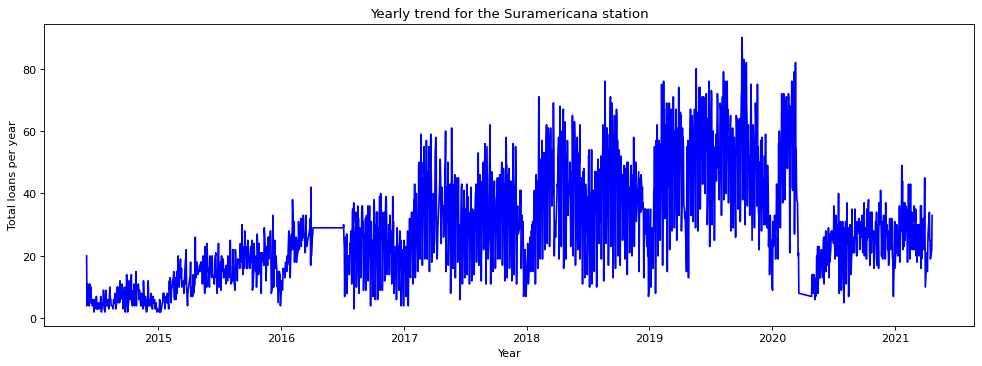

In [122]:
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(Suramericana_station_df, color = 'blue')

plt.title("Yearly trend for the Suramericana station")
plt.xlabel('Year')
plt.ylabel('Total loans per year')
plt.show()

Again we see a similar trend,were the bike sharing increasing during 2018-2020 and 2020 half it dropped maybe due to covid

Station 3: Floresta station

In [123]:
Floresta_station = df[df['Origin_station_description']=='Floresta']
Floresta_station.head()

,Bike_Tag_ID,Loan_start_date_time,Loan_stop_date_time,Origin_loan_station_ID,Position_number_bike_origin,Return_loan_station_ID,Position_number_bike_destination,operator_presence,Origin_station_description,origin_station_slots,Origin_Lat,Origin_Lon,Origin_isManual,Return_station_description,return_station_slots,Return_Lat,Return_Lon,Return_isManual
3,0000EC016FE2,2020-05-09 11:12:55.000,2020-05-09 11:35:38.000,12,1,89.0,14.0,Absent,Floresta,20.0,"6,258628","-75,597366",1.0,Málaga,20.0,"6,24655","-75,569954",0.0
28,000017AFA4C1,2015-10-21 07:54:33.000,2015-10-21 08:03:35.000,12,1,13.0,1.0,Present,Floresta,20.0,"6,258628","-75,597366",1.0,Robledo,21.0,"6,271922","-75,591324",1.0
38,000017AFADCD,2018-01-19 16:27:40.000,2018-01-19 17:03:38.000,12,1,54.0,1.0,Present,Floresta,20.0,"6,258628","-75,597366",1.0,Primavera,40.0,"6,2253","-75,572449",1.0
86,000017B02C1F,2017-02-01 13:48:13.000,2017-02-01 13:59:41.000,12,1,13.0,1.0,Present,Floresta,20.0,"6,258628","-75,597366",1.0,Robledo,21.0,"6,271922","-75,591324",1.0
88,001D70222B5E,2019-06-25 08:09:17.000,2019-06-25 08:18:22.000,12,1,8.0,1.0,Present,Floresta,20.0,"6,258628","-75,597366",1.0,Estadio,20.0,"6,253349","-75,587692",1.0


In [124]:
Floresta_station['Loan_start_date_time'] = pd.to_datetime(Floresta_station['Loan_start_date_time']).dt.date
Floresta_station_yearly_loans = Floresta_station.groupby(["Loan_start_date_time"])["Origin_loan_station_ID"].count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [125]:
Floresta_station_df= pd.DataFrame(Floresta_station_yearly_loans)#Convert the series into dataframe
Floresta_station_df.columns =['Total Loans']#rename the columns for better understanding
Floresta_station_df

,Total Loans
Loan_start_date_time,
2014-06-03,7
2014-06-04,4
2014-06-05,3
2014-06-06,3
2014-06-09,2
...,...
2021-04-13,23
2021-04-14,27
2021-04-15,26


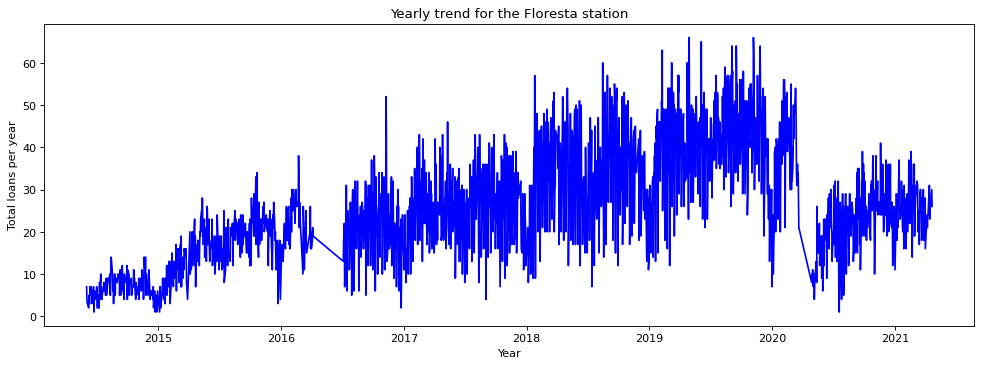

In [126]:
plt.figure(figsize=(15, 5), dpi=80)
plt.plot(Floresta_station_df, color = 'blue')

plt.title("Yearly trend for the Floresta station")
plt.xlabel('Year')
plt.ylabel('Total loans per year')
plt.show()

Again we see a similar trend,were the bike sharing increasing during 2018-2020 and 2020 half it dropped maybe due to covid

### Benchmark model: Random Forest Regressor

In [75]:
# Drop the date for the simple benchmark model
df = df.drop('Loan_start_date_time',axis=1)
df = df.drop('Loan_stop_date_time',axis=1)

In [76]:
df.head()

,Bike_Tag_ID,Origin_loan_station_ID,Position_number_bike_origin,Return_loan_station_ID,Position_number_bike_destination,operator_presence,Origin_station_description,origin_station_slots,Origin_Lat,Origin_Lon,Origin_isManual,Return_station_description,return_station_slots,Return_Lat,Return_Lon,Return_isManual
0,SA23,27,1,28.0,1.0,Present,Sabaneta Parque,1.0,"6,151631","-75,615623",1.0,Sabaneta Metro,1.0,"6,1568288","-75,616668",1.0
1,000017AFBE15,64,13,59.0,21.0,Absent,MAMM,38.0,"6,22378","-75,574966",0.0,Río Aburrá,26.0,"6,22851","-75,574658",0.0
2,000017AFBBCF,60,25,36.0,28.0,Absent,Villa Carlota,26.0,"6,220012","-75,575431",0.0,Parque de Las Luces I,28.0,"6,246078","-75,571561",0.0
3,0000EC016FE2,12,1,89.0,14.0,Absent,Floresta,20.0,"6,258628","-75,597366",1.0,Málaga,20.0,"6,24655","-75,569954",0.0
4,003567222B5E,66,1,47.0,20.0,Absent,Industriales Metroplús,20.0,"6,231406","-75,577222",1.0,Circular Primera,24.0,"6,241859","-75,591929",0.0


In [77]:
# Drop NaN values
df = df.dropna()

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329383 entries, 0 to 1329382
Data columns (total 16 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Bike_Tag_ID                       1329383 non-null  object 
 1   Origin_loan_station_ID            1329383 non-null  int64  
 2   Position_number_bike_origin       1329383 non-null  int64  
 3   Return_loan_station_ID            1329383 non-null  float64
 4   Position_number_bike_destination  1329383 non-null  float64
 5   operator_presence                 1329383 non-null  object 
 6   Origin_station_description        1329383 non-null  object 
 7   origin_station_slots              1329383 non-null  float64
 8   Origin_Lat                        1329383 non-null  object 
 9   Origin_Lon                        1329383 non-null  object 
 10  Origin_isManual                   1329383 non-null  float64
 11  Return_station_description        132

In [79]:
df['Bike_Tag_ID'] = df['Bike_Tag_ID'].astype(str)
df['Origin_station_description'] = df['Origin_station_description'].astype(str)
df['Origin_Lat'] = df['Origin_Lat'].astype(str)
df['Origin_Lon'] = df['Origin_Lon'].astype(str)
df['Return_Lat'] = df['Return_Lat'].astype(str)
df['Return_Lon'] = df['Return_Lon'].astype(str)
df['Return_station_description'] = df['Return_station_description'].astype(str)

In [80]:
# Encoding of the categorical variables
# https://www.hackdeploy.com/python-one-hot-encoding-with-scikit-learn/
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

from sklearn.preprocessing import LabelEncoder

le_Bike_Tag_ID = LabelEncoder()
le_Origin_loan_station_ID = LabelEncoder()
le_Position_number_bike_origin = LabelEncoder()
le_Return_loan_station_ID = LabelEncoder()
le_Position_number_bike_destination = LabelEncoder()
le_operator_presence = LabelEncoder()
le_Origin_station_description = LabelEncoder()
le_Origin_Lat = LabelEncoder()
le_Origin_Lon = LabelEncoder()
le_Origin_isManual = LabelEncoder()
le_Return_station_description = LabelEncoder()
le_return_station_slots = LabelEncoder()
le_Return_Lat = LabelEncoder() 
le_Return_Lon = LabelEncoder()
le_Return_isManual = LabelEncoder()

df['Bike_Tag_ID'] = le_Bike_Tag_ID.fit_transform(df.Bike_Tag_ID)
df['Origin_loan_station_ID'] = le_Origin_loan_station_ID.fit_transform(df.Origin_loan_station_ID)
df['Position_number_bike_origin'] = le_Position_number_bike_origin.fit_transform(df.Position_number_bike_origin)
df['Return_loan_station_ID'] = le_Return_loan_station_ID.fit_transform(df.Return_loan_station_ID)
df['Position_number_bike_destination'] = le_Position_number_bike_destination.fit_transform(df.Position_number_bike_destination)
df['operator_presence'] = le_operator_presence.fit_transform(df.operator_presence)
df['Origin_station_description'] = le_Origin_station_description.fit_transform(df.Origin_station_description)
df['Origin_Lat'] = le_Origin_Lat.fit_transform(df.Origin_Lat)
df['Origin_Lon'] = le_Origin_Lon.fit_transform(df.Origin_Lon)
df['Origin_isManual'] = le_Origin_isManual.fit_transform(df.Origin_isManual)
df['Return_station_description'] = le_Return_station_description.fit_transform(df.Return_station_description)
df['return_station_slots'] = le_return_station_slots.fit_transform(df.return_station_slots)
df['Return_Lat'] = le_Return_Lat.fit_transform(df.Return_Lat)
df['Return_Lon'] = le_Return_Lon.fit_transform(df.Return_Lon)
df['Return_isManual'] = le_Return_isManual.fit_transform(df.Return_isManual)

df.head()

,Bike_Tag_ID,Origin_loan_station_ID,Position_number_bike_origin,Return_loan_station_ID,Position_number_bike_destination,operator_presence,Origin_station_description,origin_station_slots,Origin_Lat,Origin_Lon,Origin_isManual,Return_station_description,return_station_slots,Return_Lat,Return_Lon,Return_isManual
0,6552,18,0,19,0,1,85,1.0,5,97,1,84,0,11,99,1
1,956,50,12,45,20,0,38,38.0,44,22,0,82,11,46,20,0
2,946,46,24,24,27,0,101,26.0,39,24,0,59,13,75,11,0
3,4131,10,0,55,13,0,22,20.0,92,83,1,48,7,76,8,0
4,4705,52,0,35,19,0,28,20.0,49,28,1,12,10,59,60,0


In [81]:
# Separate into variables and target variable
selected_variables = ['Bike_Tag_ID',
                      'Origin_loan_station_ID',
                      'Position_number_bike_origin',
                      'Return_loan_station_ID',
                      'Position_number_bike_destination',
                      'operator_presence',
                      'Origin_station_description',
                      'Origin_Lat',
                      'Origin_Lon',
                      'Origin_isManual',
                      'Return_station_description',
                      'return_station_slots',
                      'Return_Lat',
                      'Return_Lon',
                      'Return_isManual']

X= df.loc[:,selected_variables].values

In [82]:
# Separate into variables and target variable
y=df.loc[:,'origin_station_slots'].values

In [83]:
# Split the dataset into train and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [84]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [85]:
y_pred_rfr=reg.predict(X_test)

In [87]:
print(f"The MSE of the test data set : {mean_squared_error(y_test,y_pred_rfr)}")

The MSE of the test data set : 51.10797480229492


In [88]:
# Use Grid Search to improve (minimize) the MSE score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor as DT
dt=DT()
max_depth=[x for x in range(1,5)]
param_grid=dict(max_depth=max_depth)
searcher=GridSearchCV(estimator=dt,param_grid=param_grid,cv=5)
searcher.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [89]:
searcher.best_estimator_.fit(X_train,y_train)
y_pred_dt=searcher.best_estimator_.predict(X_test)
print(f"The MSE of the test data set : {mean_squared_error(y_pred_dt,y_test)}")

The MSE of the test data set : 30.020952098185298


## Conclusions
We were able to build a model to predict the number of slots for each station of origin. Using this model, it would be possible to optimize the number of available spaces in each station to maximize the number of users.

### Scalability and Impact

Our exploratory analysis also shows that an event such as COVID impacts the demand and that this type of event has to be considered. 

### Future Work

For this dataset, we ran into a computing issue using Google Collab, so a model was created with a small fraction of the original dataset.

In the future, this problem could be resolve by using a service such as a Saturn Cloud, which would allow running our analysis on a cluster of GPUs and should allow to speed up the notebook runtime. 